In [ ]:
import numpy as np
from numpy import random
import torch 
import torchvision
from torchvision import datasets
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from random import choice
from random import uniform
from numpy.random import randint

In [ ]:
transformer=transforms.Compose([
    transforms.Resize((140,140)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
               
    
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Grayscale(num_output_channels=3),
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
num_classes=4
num_batches=16
num_epochs=50

In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path='/content/drive/MyDrive/brain_mri_images (1)/Training'
test_path='/content/drive/MyDrive/brain_mri_images (1)/Testing'
train_loader=DataLoader(torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=num_batches, shuffle=True)
test_loader=DataLoader(torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=num_batches, shuffle=True)
classes= ('glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor')
print(f'Number of training examples: {len(train_loader)}')
#print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_loader)}')

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
#print(labels.shape)



Number of training examples: 22
Number of testing examples: 4
torch.Size([16, 3, 140, 140])


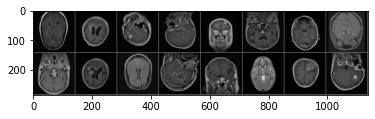

no_tumor glioma_tumor glioma_tumor glioma_tumor meningioma_tumor pituitary_tumor glioma_tumor no_tumor pituitary_tumor glioma_tumor no_tumor glioma_tumor pituitary_tumor no_tumor meningioma_tumor glioma_tumor


In [ ]:
def imshow(img):
    img=img/2 +.5               #% x= (x-mean)/std
    npimage=img.numpy()
    plt.imshow(np.transpose(npimage, (1,2,0)))
    plt.show()
dataiter= iter(train_loader)
images, lables= dataiter.next()
imshow(torchvision.utils.make_grid(images))
print (' '.join('%5s' %classes[lables[j]]
for j in range(16)))

In [ ]:

def accuracy(y_pred, y):
    top_pred= y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc
  

In [ ]:
def CNN_Model(f1, f2, f3, k1, k2, k3, l_r ):

  class Net(nn.Module):
      def __init__(self, f1, f2, f3, k1, k2, k3):
          super(Net, self).__init__()
          self.conv1=nn.Conv2d(in_channels=3,out_channels=f1 ,kernel_size=k1,stride=1,padding=1)
          self.bn1=nn.BatchNorm2d(num_features=f1)
          self.relu1=nn.ReLU()
          self.pool=nn.MaxPool2d(kernel_size=2)
        
          self.conv2=nn.Conv2d(in_channels=f1,out_channels= f2, kernel_size=k2,stride=1,padding=1)
          self.relu2=nn.ReLU()
        
          self.conv3=nn.Conv2d(in_channels=f2,out_channels=f3,kernel_size=k3,stride=1,padding=1)
        
          self.bn3=nn.BatchNorm2d(num_features=f3)
          self.relu3=nn.ReLU()
          self.drop_out = nn.Dropout()
          v=((140-k1+ 2+1)/2 )
          u=(v-k2+ 2+1)
          w=(u-k3+ 2+1)
          self.fc1=nn.Linear(in_features= int(w)*int(w)*int(f3), out_features=4)
        
      def forward(self,input):
          output=self.conv1(input)
          output=self.bn1(output)
          output=self.relu1(output)
            
          output=self.pool(output)
            
          output=self.conv2(output)
          output=self.relu2(output)
            
          output=self.conv3(output)
          output=self.bn3(output)
          output=self.relu3(output)
          output=self.drop_out(output)
          output=output.view(output.size(0), -1)
            
            
          output=self.fc1(output)
          return output

  model = Net(f1, f2, f3, k1, k2, k3)

  optimizer = optim.Adam(model.parameters(), lr=l_r)
  criterion = nn.CrossEntropyLoss()
  if torch.cuda.is_available():
      model = model.cuda()
      criterion = criterion.cuda()
    
  print(model)
  trainacc_values=[]
  trainloss_values=[]
  testacc_values=[]
  testloss_values=[]
  for i in range(num_epochs):
      train_loss = 0
      train_acc=0
      for images, labels in train_loader:

          if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

          # Training pass
          optimizer.zero_grad()
          output= model(images)
          loss = criterion(output, labels)
          acc=accuracy(output, labels)
          #This is where the model learns by backpropagating
          loss.backward()
        
          #And optimizes its weights here
          optimizer.step()
        
          train_loss += loss.item()
          train_acc += acc.item()
     
      trainacc_values.append(train_acc/len(train_loader))
      trainloss_values.append(train_loss/len(train_loader))

      test_loss = 0
      test_acc=0
      for images, labels in test_loader:

          if torch.cuda.is_available():
            images= images.cuda()
            labels= labels.cuda()

          optimizer.zero_grad()
          output= model(images)
        
          loss= criterion(output, labels)
          acc=accuracy(output, labels)
          
        
          test_loss += loss.item()
          test_acc += acc.item()
        
      print("Test loss: {} , test accuracy: {}".format( test_loss/len(test_loader) , test_acc/len(test_loader)))
      testacc_values.append(test_acc/len(test_loader))
      testloss_values.append(test_loss/len(test_loader))
  print(  max(testacc_values))
  return max(testacc_values)      
#CNN_Model(16, 24, 42, 3)

In [ ]:

def initialization():  
  parameters = {}
  f1 = choice([16, 24, 32])
  parameters["f1"] = f1
  f2 = choice([ 40, 64, 128, 80])
  parameters["f2"] = f2
  f3 = choice([44, 128, 64, 196])
  parameters["f3"] = f3
  k1 = choice([17,3,7, 11])
  parameters["k1"] = k1
  k2 = choice([17,3,7, 11])
  parameters["k2"] = k2
  k3 = choice([17, 3,7, 11])
  parameters["k3"] = k3
  l_r= choice([0.001, 0.01, 0.005, 0.0075])
  parameters["l_r"]= l_r
  return parameters

def generate_population(n):
  population = []
  for i in range(n):
    chromosome = initialization()
    population.append(chromosome)
  print(population)
  return population
#generate_population(10)

In [ ]:
# Roulette wheel selection method
def selection(population_fitness):
  total = sum(population_fitness)
  percentage = [round((x/total) * 100) for x in population_fitness]
  selection_wheel = []
  for pop_index,num in enumerate(percentage):
    selection_wheel.extend([pop_index]*num)
  parent1_ind = choice(selection_wheel)
  parent2_ind = choice(selection_wheel)
  return [parent1_ind, parent2_ind]

In [ ]:
def crossover(parent1, parent2):
  child1 = {}
  child2 = {}

  child1["f1"] = choice([parent1["f1"], parent2["f1"]])
  child1["f2"] = choice([parent1["f2"], parent2["f2"]])
  child1["f3"] = choice([parent1["f3"], parent2["f3"]])

  child2["f1"] = choice([parent1["f1"], parent2["f1"]])
  child2["f2"] = choice([parent1["f2"], parent2["f2"]])
  child2["f3"] = choice([parent1["f3"], parent2["f3"]])

  child1["k1"] = choice([parent1["k1"], parent2["k1"]])
  child1["k2"] = choice([parent1["k2"], parent2["k2"]])
  child1["k3"] = choice([parent1["k3"], parent2["k3"]])

  child2["k1"] = choice([parent1["k1"], parent2["k1"]])
  child2["k2"] = choice([parent1["k2"], parent2["k2"]])
  child2["k3"] = choice([parent1["k3"], parent2["k3"]])

  child1["l_r"] = parent1["l_r"]
  child2["l_r"] = parent2["l_r"]

  return [child1, child2]

In [ ]:
def mutation(chromosome):
  flag = randint(0,40)
  fil=['f1', 'f2', 'f3']
  x= random.choice(fil)
    
  if x=="f1": 
      chromosome[0] += 20
      print(chromosome)
  elif x=="f2":
      chromosome[1] += 32
      print(chromosome)

  else:
      chromosome[2] += 48
      print(chromosome)

  return chromosome
#child=[32, 44, 64, 7, 0.01]
#mutation (child)

In [ ]:
generations = 10
threshold = 90
num_pop = 10

population = generate_population(num_pop)

for generation in range(generations):

  population_fitness = []
  for chromosome in population:
    f1 = chromosome["f1"]
    f2 = chromosome["f2"]
    f3 = chromosome["f3"]
    k1 = chromosome["k1"]
    k2 = chromosome["k2"]
    k3 = chromosome["k3"]
    l_r = chromosome["l_r"]
    

    try:
      print("Parameters: ", chromosome)
      acc = CNN_Model(f1, f2, f3, k1, k2, k3, l_r)
       
      
      print("Accuracy: ", round(acc,3))
    except:
      acc=0
      print("Parameters: ", chromosome)
      print("Invalid parameters - Build fail")

    population_fitness.append(acc)
    
  parents_ind = selection(population_fitness)
  parent1 = population[parents_ind[0]]
  parent2 = population[parents_ind[1]]

  children = crossover(parent1, parent2)
  child1 = mutation(children[0])
  child2 = mutation(children[1])

  population.append(child1)
  population.append(child2)

  print("Generation ", generation+1," Outcome: ")
  if max(population_fitness) >= threshold:
    print("Obtained desired accuracy: ", max(population_fitness))
    break
  else:
    print("Maximum accuracy in generation {} : {}".format(generation+1, max(population_fitness)))

  first_min = min(population_fitness)
  first_min_ind = population_fitness.index(first_min)
  population.remove(population[first_min_ind])
  second_min = min(population_fitness)
  second_min_ind = population_fitness.index(second_min)
  population.remove(population[second_min_ind])
  print("new population :  ",  population)

[{'f1': 32, 'f2': 64, 'f3': 64, 'k1': 11, 'k2': 11, 'k3': 11, 'l_r': 0.01}, {'f1': 16, 'f2': 128, 'f3': 44, 'k1': 7, 'k2': 17, 'k3': 7, 'l_r': 0.005}, {'f1': 24, 'f2': 64, 'f3': 44, 'k1': 11, 'k2': 3, 'k3': 11, 'l_r': 0.001}, {'f1': 24, 'f2': 80, 'f3': 44, 'k1': 7, 'k2': 11, 'k3': 7, 'l_r': 0.001}, {'f1': 24, 'f2': 80, 'f3': 44, 'k1': 3, 'k2': 7, 'k3': 11, 'l_r': 0.005}, {'f1': 32, 'f2': 80, 'f3': 44, 'k1': 17, 'k2': 17, 'k3': 7, 'l_r': 0.0075}, {'f1': 32, 'f2': 80, 'f3': 128, 'k1': 7, 'k2': 3, 'k3': 11, 'l_r': 0.01}, {'f1': 16, 'f2': 64, 'f3': 128, 'k1': 17, 'k2': 17, 'k3': 11, 'l_r': 0.01}, {'f1': 16, 'f2': 64, 'f3': 44, 'k1': 7, 'k2': 7, 'k3': 7, 'l_r': 0.01}, {'f1': 32, 'f2': 64, 'f3': 44, 'k1': 7, 'k2': 17, 'k3': 11, 'l_r': 0.01}]
Parameters:  {'f1': 32, 'f2': 64, 'f3': 64, 'k1': 11, 'k2': 11, 'k3': 11, 'l_r': 0.01}
Net(
  (conv1): Conv2d(3, 32, kernel_size=(11, 11), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

KeyError: ignored

In [ ]:
 
plt.plot(trainloss_values, 'g', label='Training loss')
plt.plot(testloss_values, 'b', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [ ]:
 
plt.plot(trainacc_values, 'g', label='Training accuracy')
plt.plot(testacc_values, 'b', label='Test accuracy')
plt.title('Training and Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.show()


In [ ]:
0.00075 --- 10) 84, 74 . 20) 90 ,93
0.001  --- 10) 69, 75. 20) 92 93
0.0005 --- 10) 85, 80 . 20) 88, 89
0.0001 -- 10) 82, 76 . 20) 94, 89

In [ ]:
def initialization():  
  parameters = {}
  f1 = choice([16, 24, 32])
  parameters["f1"] = f1
  f2 = choice([ 32,40, 64, 80])
  parameters["f2"] = f2
  f3 = choice([40, 64, 128])
  parameters["f3"] = f3
  k = choice([3,7, 13])
  parameters["k"] = k
  l_r= choice([0.001, 0.00025, 0.0005, 0.00075])

  
  return parameters

def generate_population(n):
  population = []
  for i in range(n):
    chromosome = initialization()
    population.append(chromosome)
  return population


return max(testacc_values)

